In [1]:
import cv2
import utm
import json
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.affinity import rotate, scale


def mask_to_shapely_polygon(mask_image_path):
    # 1. Read the image and ensure it's a binary mask
    image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not read image from {mask_image_path}")
        return None

    # Ensure the image is properly thresholded (binary: 0 or 255)
    # The second return value 'thresh' is the binary image
    _, binary_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    binary_mask = cv2.bitwise_not(binary_mask)
    binary_mask = cv2.flip(binary_mask, 0)
    
    # 2. Find contours
    # cv2.RETR_EXTERNAL retrieves only external contours (good for simple shapes)
    # cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3. Convert contours to Shapely polygons
    polygons = []
    for contour in contours:
        # Squeeze extra dimensions and ensure the contour has enough points for a polygon
        if contour.shape[0] >= 3:
            # Coordinates from OpenCV are typically (x, y). Shapely uses the same.
            points = np.squeeze(contour)
            # Check if points is a 1D array (happens with only 3 points) and convert if needed
            if points.ndim == 1:
                points = [tuple(points)]
            
            try:
                polygon = Polygon(points)
                # Check for valid polygon and potential holes
                if polygon.is_valid:
                    polygons.append(polygon)
                else:
                    # Attempt to fix invalid polygons, or use unary_union to process complex ones
                    # For simplicity, we just add it if possible
                    polygons.append(polygon.buffer(0)) 
            except Exception as e:
                print(f"Could not create Polygon from contour: {e}")

    # 4. Return as a single MultiPolygon if multiple objects are found, or a single Polygon
    if not polygons:
        return None
    elif len(polygons) == 1:
        return polygons[0]
    else:
        return Polygon(polygons)
    

def replace_geofence_in_plan(fname, geofence_points, out_fname=None):
    """
    Replace the first geofence polygon in a QGC .plan file with geofence_points
    and save the updated plan JSON back to disk.

    Parameters
    ----------
    fname : str
        Input .plan file path.
    geofence_points : np.ndarray or list-like
        Expected shape (N,2) for [lat, lon] or (N,3) for [lat, lon, alt] (alt dropped).
    out_fname : str or None
        Output file path. If None, overwrites fname.
    """
    out_fname = fname if out_fname is None else out_fname

    # Load plan JSON
    with open(fname, "r") as infile:
        data = json.load(infile)

    # [lat, lon]
    vertices = np.asarray(geofence_points, dtype=float)
    if vertices.ndim != 2 or vertices.shape[1] < 2:
        raise ValueError(
            f"geofence_points must be a 2D array with at least 2 columns (lat, lon). Got shape {vertices.shape}."
        )
    vertices = vertices[:, :2]

    if vertices.shape[0] < 3:
        raise ValueError("geofence_points must contain at least 3 points to form a polygon.")

    # Ensure expected structure exists
    if "geoFence" not in data:
        data["geoFence"] = {}
    if "polygons" not in data["geoFence"] or not data["geoFence"]["polygons"]:
        # Create a default polygon container if missing
        data["geoFence"]["polygons"] = [{"polygon": []}]
    if "polygon" not in data["geoFence"]["polygons"][0]:
        data["geoFence"]["polygons"][0]["polygon"] = []

    # Write back polygon as JSON-serializable list
    data["geoFence"]["polygons"][0]["polygon"] = vertices.tolist()

    # Save updated plan
    with open(out_fname, "w") as outfile:
        json.dump(data, outfile, indent=2)

    return out_fname

Sq length: 14.70480193678241 Area (sqm): 216.23119999999972


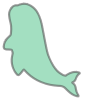

In [2]:
# Generate polygon
result_polygon = mask_to_shapely_polygon('./raster.png')
result_polygon = scale(result_polygon, 0.04, 0.04)
result_polygon = rotate(result_polygon, -65, origin='center')
print("Sq length:", np.sqrt(result_polygon.area), "Area (sqm):", result_polygon.area)
result_polygon

In [3]:
# Shift origin
points = np.array(result_polygon.exterior.coords)
points -= points[275]

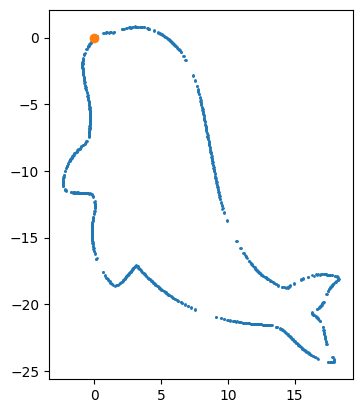

In [4]:
# Plot
plt.scatter(points[:, 0], points[:, 1], s=1)
plt.scatter(0, 0)
plt.gca().set_aspect('equal')

In [5]:
# Fit to start location
origin = [13.191698018037107, -59.641000262827376,]
encoding = utm.from_latlon(origin[0], origin[1])
offset = np.array([encoding[:2]])
encoding = encoding[2:]

# Map to geo coords
X = utm.to_latlon(points[:, 0]+offset[:, 0], points[:, 1]+offset[:, 1], 
                  encoding[0], encoding[1])
X = np.vstack([X[0], X[1]]).T

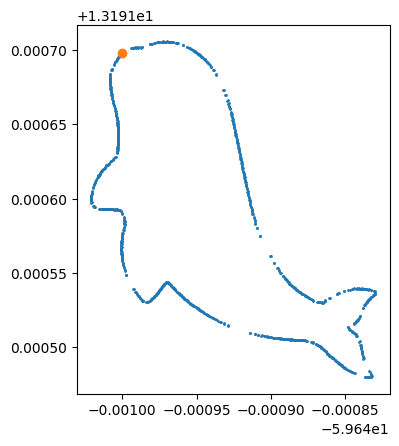

In [6]:
# Plot
plt.scatter(X[:, 1], X[:, 0], s=1)
plt.scatter(origin[1], origin[0])
plt.gca().set_aspect('equal')

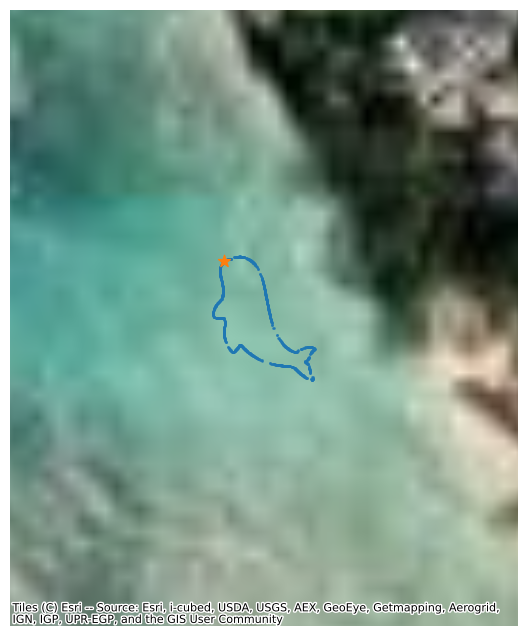

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

lats, lons = X[:, 0], X[:, 1]
pts = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lons, lats), crs="EPSG:4326").to_crs(3857)
org = gpd.GeoDataFrame(geometry=gpd.points_from_xy([origin[1]], [origin[0]]), crs="EPSG:4326").to_crs(3857)

fig, ax = plt.subplots(figsize=(8, 8))
pts.plot(ax=ax, markersize=1, alpha=0.7)
org.plot(ax=ax, markersize=80, marker="*", zorder=5)

# ---- Show bigger map area: pad bounds in Web Mercator (EPSG:3857)
xmin, ymin, xmax, ymax = pts.total_bounds
pad_frac = 2.0  # <- increase this (e.g., 0.5, 1.0, 2.0) to zoom out more
dx = (xmax - xmin) * pad_frac
dy = (ymax - ymin) * pad_frac

# Clamp to valid Web Mercator range to avoid "no tiles" issues
WM = 20037508.342789244
ax.set_xlim(np.clip(xmin - dx, -WM, WM), np.clip(xmax + dx, -WM, WM))
ax.set_ylim(np.clip(ymin - dy, -WM, WM), np.clip(ymax + dy, -WM, WM))

# ---- Choose a valid zoom (compute from lon/lat bounds), then back off more to zoom out
w, s, e, n = lons.min(), lats.min(), lons.max(), lats.max()
z = ctx.tile._calculate_zoom(w, s, e, n)
z = int(np.clip(z, 0, 19))      # Esri.WorldImagery supports 0..19
z = max(0, z - 3)               # <- increase (e.g., -2, -3, -4) to zoom out more

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=z)

ax.set_axis_off()
ax.set_aspect("equal")
plt.show()

In [8]:
# Save to mission plan
replace_geofence_in_plan("mission.plan", X)

'mission.plan'